In [ ]:
import os
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import myServices as ms
import models as md
import numpy as np
import pandas as pd
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_curve, auc, roc_auc_score, f1_score
import joblib

In [ ]:
# to compute ececution time do: 
# with timeit():
#     # your code, e.g., 
class timeit(): 
    from datetime import datetime
    def __enter__(self):
        self.tic = self.datetime.now()
    def __exit__(self, *args, **kwargs):
        print('runtime: {}'.format(self.datetime.now() - self.tic))

## Importing and manipulating datasets

In [ ]:
sklearn.metrics.get_scorer_names()

In [ ]:
### Cleaning basin1DataSet 
dataSetPath = 'basin5_RawData.csv'
basinDataSet = pd.read_csv(dataSetPath, index_col = None)
# basin1Light = pd.read_csv('datasetBasin1_NoDataFree.csv', index_col = None)
print(basinDataSet.info())
basinDataSet.describe()

In [ ]:
basinDataSet.isna().any()

In [ ]:
basinDataSet['percentage'].unique()
Counter(basinDataSet['percentage'])

In [ ]:
basinDataSet.isna().sum()

In [ ]:
basinDataSet.dropna(inplace=True)

In [ ]:
basinDataSet['FAProx_01'].fillna(0,inplace=True)

In [ ]:
basinDataSet.isna().sum()
# print(basinDataSet['FAcc'].max())

In [ ]:
#### NOrmalize Flow Accumulation
basinDataSet['FAcc'] = (basinDataSet['FAcc']- basinDataSet['FAcc'].min())/(basinDataSet['FAcc'].max()-basinDataSet['FAcc'].min())


In [ ]:
print(len(basinDataSet['FAProx_01']))
basinDataSet['FAProx_01'] = [print(0) if basinDataSet['FAProx_01'][i].isna()
                             else print(basinDataSet['FAProx_01'][i]) 
                             for i  in range(len(basinDataSet['FAProx_01']))]

In [ ]:
basinDataSet.describe()

In [ ]:
basinDataSet.to_csv('datasets/basin5_Clean.csv', index=None)

In [ ]:
### Making quadratic transformation in Labels for regression
DS = pd.read_csv('datasets/basin5_Clean.csv', index_col = None)
print(Counter(DS['percentage']))

# y_Quad = md.quadraticRechapeLabes(DS['percentage'], -0.125, 0.825)
# DS['percentage'] = y_Quad
# print(Counter(DS['percentage']))
# DS.to_csv('basin1TrainUnbalanced_QuadTarget.csv', index = None)

In [ ]:
ds = DS.head(5)
s = {}
s['Datas'] = ds
print(s)

## balanced sampling

In [ ]:
## Stratified Split
from sklearn.model_selection import StratifiedShuffleSplit

X,Y = ms.importDataSet('datasets/basin5_Clean.csv', 'percentage')
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=50)
for train_index, test_index in sss.split(X, Y):
    print("TRAIN:", train_index.size, "TEST:", test_index.size)
    X_train = X.iloc[train_index]
    y_train = Y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = Y.iloc[test_index]

In [ ]:
print(len(X_train['elevation']), len(y_train) )
Counter(y_train)

In [ ]:
#####. Creating training set
print(X_train.head())
X_train.loc[:,'percentage'] = y_train
# print(X_train.info())

In [ ]:
print(X_train.head())
Counter(X_train['percentage'])

In [ ]:
X_train.drop(['x_coord','y_coord'], axis =1, inplace=True)
X_train.head()

In [ ]:
X_train.to_csv('datasets/basin5_Training.csv', index=None)

In [ ]:
#####. Creating training set
print(X_test.head())
X_test.loc[:,'percentage'] = y_test
print(X_test.head())
print(X_test.info())


In [ ]:
Counter(X_test['percentage'])

In [ ]:
X_test.to_csv('datasets/basin5_Test.csv', index=None)

In [ ]:
## This proportions are the reason why a sample_weight of 0.01 for the majority class give best results for regression
totalTrain = sum([499833, 12477, 2354])
totalValidation = sum([124958, 3120, 588])
print("Summary of traning and test dataset class balance")
print(f"Training Set:", '\n', "Class 0: %.3f" %(499833/totalTrain), " Class 1: %.4f" %(2354/totalTrain), "Class 5: %.4f"%(12477/totalTrain))
print("Testing Set:", '\n', "Class 0: %.3f" %(124958/totalValidation)," Class 1: %.4f" %(588/totalValidation),  "Class 5: %.4f"%(3120/totalValidation))



In [ ]:
print(totalValidation)

In [ ]:
model = ms.loadModel('./outputs/2022-08-05/00-35-58/2208050035.pkl')
dataSetToSave = ms.makePredictionToImportAsSHP(csvName, model, X, Y, 'percentage')
print(dataSetToSave.head())

## Controled sampling

In [ ]:
DS = pd.read_csv('basin1Light_Clean_Training.csv', index_col = None)
print(DS.head())


In [ ]:
print(DS.columns)

In [ ]:
plt.boxplot(DS['FAcc']) # , , DS['elevation'], DS['disToRiv']]

In [ ]:
## Resampling appliying class selection by rule:

# RULE1: Select point at a distance to river less than 300m. 

# # newDS = pseudoClassCreation(DS, "distanceToRiver", 300, 2)
def pseudoClassCreation(dataset, conditionVariable, threshold, pseudoClass, targetClassName):
    '''
    Replace <targetClass> by  <pseudoClass> where <conditionVariable >= threshold>. 
    Return:
      dataset with new classes group. 
    '''
    datsetReclassified = dataset.copy()
    actualTarget = (np.array(dataset[targetClassName])).ravel()
    conditionVar = (np.array(dataset[conditionVariable])).ravel()
    datsetReclassified[targetClassName] = [ pseudoClass if conditionVar[j] >= threshold 
                                           else actualTarget[j]
                                           for j in range(len(actualTarget))]
    print(Counter(datsetReclassified[targetClassName]))
    return  datsetReclassified

def revertPseudoClassCreation(dataset, originalClass, pseudoClass, targetClassName):
    '''
    Restablich  <targetClass> with <originalClass> where <targetClassName == pseudoClass>. 
    Return:
      dataset with original classes group. 
    '''
    datsetReclassified = dataset.copy()
    actualTarget = (np.array(dataset[targetClassName])).ravel()
    datsetReclassified[targetClassName] = [ originalClass if actualTarget[j] == pseudoClass
                                           else actualTarget[j]
                                           for j in range(len(actualTarget))]
    print(Counter(datsetReclassified[targetClassName]))
    return  datsetReclassified


print(Counter(X_train['percentage']))
newDS = pseudoClassCreation(X_train, 'disToRiv', 200, 2, 'percentage')
y = newDS['percentage']
newDS.drop(['percentage'], axis=1, inplace = True)
x_res,y_res = ms.randomUndersampling(newDS, y, )
x_res['percentage'] = y_res
# newDatase = revertPseudoClassCreation(x_res, 0, 2, 'percentage')


In [ ]:
x_res.to_csv('basin1ControlClass0Sampling4Class_ToSHP.csv',index = None)

# Data description and visualization

In [48]:
#### import dataset to describe

DS= pd.read_csv('datasets/basin1Light_Clean.csv', index_col=None)
DS.head()

,percentage,TWI,TPI,FAcc,slope,elevation,x_coord,y_coord,DLSOL4R150,DLSOL5R150,DLSOL5R200,FAProx_01,FAProx_025,visibility
0,0,12.88506,-0.04411,0.000006,8.52348,48.30993,370378,5267893,0.0,0.0,0.0,84.64632,423.23163,0.01819
1,0,12.74378,-0.08968,0.000005,10.78189,48.82024,370373,5267888,0.0,0.0,0.0,84.50444,422.52222,0.01684
2,0,12.86957,-0.03528,0.000006,8.48582,48.04361,370378,5267888,0.0,0.0,0.0,83.86894,419.34473,0.01800
3,0,12.86129,0.10560,0.000006,8.44216,47.46280,370383,5267888,0.0,0.0,0.0,83.24062,416.20306,0.02040
4,0,3.35582,-0.09266,0.000004,14.52239,49.66032,370368,5267883,0.0,0.0,0.0,84.38602,421.93008,0.01633


In [49]:
DS.drop(['x_coord','y_coord'], axis = 1, inplace=True)
DS.head()

,percentage,TWI,TPI,FAcc,slope,elevation,DLSOL4R150,DLSOL5R150,DLSOL5R200,FAProx_01,FAProx_025,visibility
0,0,12.88506,-0.04411,0.000006,8.52348,48.30993,0.0,0.0,0.0,84.64632,423.23163,0.01819
1,0,12.74378,-0.08968,0.000005,10.78189,48.82024,0.0,0.0,0.0,84.50444,422.52222,0.01684
2,0,12.86957,-0.03528,0.000006,8.48582,48.04361,0.0,0.0,0.0,83.86894,419.34473,0.01800
3,0,12.86129,0.10560,0.000006,8.44216,47.46280,0.0,0.0,0.0,83.24062,416.20306,0.02040
4,0,3.35582,-0.09266,0.000004,14.52239,49.66032,0.0,0.0,0.0,84.38602,421.93008,0.01633


In [ ]:
### FAcc vs Labels
targets = DS['percentage']
FAcc = original['FAcc']
FAcc_norm = DS['FAcc_norm']
fig, axs = plt.subplots(1, 2, figsize=(13,4), sharey=True)
fig.text(-0.02, 0.5, 'labels', va='center', rotation='vertical')
fig.text(0.5, 1, 'Flow accumulation vs labels distribution', ha ='center')
axs[0].scatter(FAcc,targets)
# axs[0].set_title("Facc")
axs[0].set(xlabel='a) Flow Accumulation')
axs[1].scatter(FAcc_norm,targets)
# axs[1].set_title("FAcc_norm")
axs[1].set(xlabel='b) Flow Accumulation estandardized')
plt.rcParams['font.size'] = '20'
fig.tight_layout()


In [ ]:

## Plot all features vs labels
# 'disToRiv', 'TWI', 'TPI', 'slope', 'elevation',

targets = DS['percentage']
# targets = np.where(targets == 5,2,targets)

E = DS['elevation'] 
slope = DS['slope']
FAcc = DS['FAcc']
TWI = DS['TWI']
TPI = DS['TPI']
DLSOL4R150 = DS['DLSOL4R150']
DLSOL5R150 = DS['DLSOL5R150']
DLSOL5R200 = DS['DLSOL5R200']
FAProx_01 = DS['FAProx_01']
FAProx_025 = DS['FAProx_025']
visibility = DS['visibility']

fig, axs = plt.subplots(4,3, figsize=(13, 8), sharey=True)
fig.supylabel('Labels')
plt.rcParams['font.size'] = '15'
plt.yticks([0,1,5])

'''
E = DS['elevation'] 
slope = DS['slope']
FAcc = DS['FAcc']
TWI = DS['TWI']
'''
axs[0, 0].scatter(E,targets)
axs[0, 0].set_title("Elevation")
axs[1, 0].scatter(slope,targets)
axs[1, 0].set_title("Slope")
axs[2, 0].scatter(FAcc,targets)
axs[2, 0].set_title("Flow accumulation")
axs[3, 0].scatter(TWI,targets)
axs[3, 0].set_title("TWI")

'''
TPI = DS['TPI']
DLSOL4R150 = DS['DLSOL4R150']
DLSOL5R150 = DS['DLSOL5R150']
DLSOL5R200 = DS['DLSOL5R200']
'''
axs[0, 1].scatter(TPI,targets)
axs[0, 1].set_title('TPI')
axs[1, 1].scatter(DLSOL4R150,targets)
axs[1, 1].set_title("DLSOL4R150")
axs[2, 1].scatter(DLSOL5R150,targets)
axs[2, 1].set_title("DLSOL5R150")
axs[3, 1].scatter(DLSOL5R200,targets)
axs[3, 1].set_title("DLSOL5R200")

'''
FAProx_01 = DS['FAProx_01']
FAProx_025 = DS['FAProx_025']
visibility = DS['visibility']
'''
axs[0, 2].scatter(FAProx_01,targets)
axs[0, 2].set_title('FAProx_01')
axs[1, 2].scatter(FAProx_025,targets)
axs[1, 2].set_title("FAProx_025")
axs[2, 2].scatter(visibility,targets)
axs[2, 2].set_title("Visibility")

fig.tight_layout()


In [ ]:
print(DS.head())
#  Return a dataset with the rows corresponding to the index where condition in DS.columName is valid. 
dsArray = DS[DS.percentage != 0] print(dsArray.head())
print(dsArray.head()) 

In [ ]:
sns.set(font_scale=1.5)
sns.pairplot(DS, hue = 'percentage', diag_kind = 'kde', 
             plot_kws = {'alpha': 0.8, 's': 100},
             height = 4, corner=True, palette = "Set2")# vars = ['life_exp', 'log_pop', 'log_gdp_per_cap'],

# sns.pairplot(DS, hue="percentage")

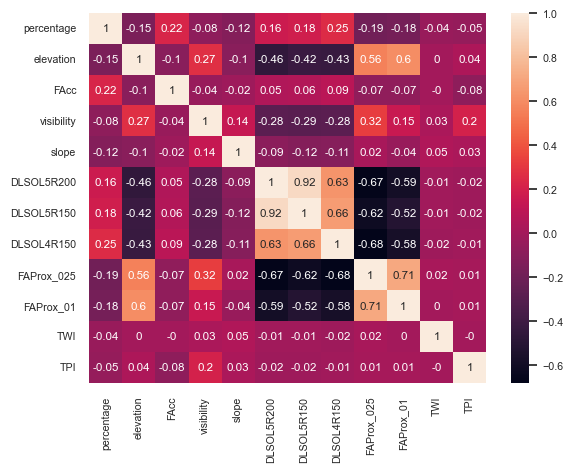

In [46]:
####. Covariance Matrix
sns.set(font_scale=0.7)
matrix = DS.corr().round(2)
sns.heatmap(matrix, annot=True)
plt.set_figsize=(25,20)
plt.show()

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(criterion='entropy', random_state = 50)
x_train,y_train = ms.importDataSet('basin1Train.csv', 'percentage')
classifier = OneVsRestClassifier(estimator).fit(x_train,y_train)


In [ ]:
classifier = ms.loadModel('./outputs/2022-08-05/11-01-57/2208051101.pkl')
x_test,y_test = ms.importDataSet('basin1Test.csv', 'percentage')

x_test = ms.removeCoordinatesFromDataSet(x_test)

# y_prob = classifier.predict_proba(x_test)
#print(np.unique(y_prob))

In [ ]:
md.plot_ROC_AUC_OneVsRest(classifier, x_test, y_test)

In [ ]:
_,y_test = ms.importDataSet('./bestModels/Classifier/10-18-08/2208051018prediction_basin1Test.csv', 'prediction')
unique, count = np.unique(y_test, return_counts=True)
total = count.sum()
print(total)
percent = np.round(np.zeros_like(unique).astype('float16'),3)
print('values, counts , percent')
for i in range(len(unique)):    
   percent[i] = (count[i]/total)*100
   print(unique[i],"\t", count[i], percent[i])
